# Milestone 5: Putting it all together

We can combine all of our dataframes that we created from the CSV files, webscraping, and API access into one database and then recall data from the database for certain operations

In [1]:
from MikesFinal import StockAnalyzer, insider_trades
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import simfin as sf
import missingno as mn
import sqlite3

In [2]:
# Setting this value to True will run all the data collection cells.
# Running these cells will take several hours

download_new_data = False

**Webscraping FinViz to get sector, industry, market cap, and country for every public stock**

In [3]:
sa = StockAnalyzer()

if download_new_data:
    screener = sa.get_data(debug=True) 
    screener.to_csv("Screener.csv", index = 0)
else:
    screener = pd.read_csv("Screener.csv")

In [4]:
screener.sample(10)

,Ticker,Company,Sector,Industry,Country,Market Cap
4073,KOR,Corvus Gold Inc.,Financial,Exchange Traded Fund,USA,NaN
1366,CLSK,"CleanSpark, Inc.",Technology,Software - Infrastructure,USA,608540000.0
7031,TSQ,"Townsquare Media, Inc.",Communication Services,Advertising Agencies,USA,208300000.0
3585,IIII,INSU Acquisition Corp. III,Financial,Shell Companies,USA,NaN
2177,ENVB,"Enveric Biosciences, Inc.",Healthcare,Biotechnology,USA,67480000.0
2452,FDEC,FT Cboe Vest US Eq Buffer ETF - December,Financial,Exchange Traded Fund,USA,NaN
164,AGD,Aberdeen Global Dynamic Dividend Fund,Financial,Closed-End Fund - Foreign,USA,NaN
3804,IWO,iShares Russell 2000 Growth ETF,Financial,Exchange Traded Fund,USA,NaN
2615,FM,iShares MSCI Frontier 100 ETF,Financial,Exchange Traded Fund,USA,NaN
4513,MHLD,"Maiden Holdings, Ltd.",Financial,Insurance - Reinsurance,Bermuda,236740000.0


**Iterating over all the unique Tickers in our screener to pull CSV files from Yahoo Finance**

In [5]:
if download_new_data:
    stock_prices, incomplete = sa.get_prices(tickers = screener['Ticker'],
                                             start = '01/01/2017', 
                                             debug = True)
    stock_prices.to_csv("Stock_Prices.csv")
    if len(incomplete) > 0:
        print(f"Unable to Pull Data for the Following Companies\n{incomplete}")
else:
    stock_prices = pd.read_csv("Stock_Prices.csv")

In [6]:
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])
stock_prices.sample(10)

,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,PctChange,CumPctChange
6069281,2018-08-30,TRIL,6.000000,6.138000,5.800000,6.000000,6.000000,245600.0,0.034483,0.052632
4093578,2019-08-29,MUR,18.230000,18.620001,18.139999,18.500000,17.330320,1714700.0,0.026637,-0.352872
271199,2020-04-30,AMS,1.560000,1.790000,1.530000,1.770000,1.770000,43400.0,0.072727,-0.479412
1852802,2019-04-16,ENIC,5.210000,5.260000,5.150000,5.230000,4.687356,149100.0,0.005769,0.243734
5456174,2019-11-27,SGOL,14.020000,14.030000,13.990000,14.010000,14.010000,354300.0,-0.004972,0.244117
4936726,2019-08-30,PTIN,24.549999,24.549999,24.379999,24.455000,24.035000,8200.0,0.002542,-0.025348
6650228,2017-03-07,WSTG,17.650000,18.350000,17.650000,18.350000,15.283153,10000.0,0.016621,0.034914
2119871,2019-07-08,FCRD,6.650000,6.670000,6.600000,6.650000,5.154546,105000.0,-0.001501,-0.102278
1067039,2020-03-24,CHRW,65.449997,67.050003,62.240002,63.549999,62.494434,2409500.0,0.004902,-0.058397
4759584,2020-09-08,PINC,32.580002,33.470001,32.180000,32.189999,31.839838,973200.0,-0.009843,0.042011


**Webscraping OpenInsider to collect insider trades for all the companies in our screener**

In [7]:
if download_new_data:
    insider_trading = insider_trades(screener['Ticker'].unique())
    insider_trading.to_csv("Insider_Trades.csv")
else:
    insider_trading = pd.read_csv("Insider_Trades.csv", index_col = 0)

In [8]:
insider_trading['Date'] = pd.to_datetime(insider_trading['Date'])
insider_trading['FilingDate'] = pd.to_datetime(insider_trading['FilingDate'])

insider_trading.sample(10)

,FilingDate,Date,Ticker,InsiderName,Title,TradeType,Price,Qty,Owned,ChangeOwned,Value
272583,2019-02-11 15:08:50,2019-02-07,UCBI,Edwards Robert A.,"EVP, CHIEF CREDIT OFFICER",A - Grant,25.98,1347.0,25832,+6%,34995.0
544151,2020-10-05 16:40:48,2020-10-01,BB,Capelli Steven M,Chief Revenue Officer,S - Sale+OE,4.42,-24269.0,388942,-6%,-107269.0
168589,2018-04-27 17:41:39,2018-04-26,INTC,Shenoy Navin,"EVP, GM - Data Center Group",S - Sale+OE,52.47,-1265.0,29513,-4%,-66379.0
65581,2017-08-15 17:44:58,2017-08-13,ESGR,O'Shea Paul James,Pres,M - OptEx,141.10,183333.0,195335,>999%,25868286.0
50319,2017-06-19 16:01:00,2017-06-15,GIII,Feller Alan,Dir,A - Grant,0.00,3878.0,22609,+21%,0.0
418170,2020-01-23 16:23:41,2020-01-21,CATC,Carotenuto Michael,"SVP , CFO",A - Grant,0.00,745.0,4470,+20%,0.0
306473,2019-03-26 16:31:20,2019-03-25,MHLD,Nigro Steven Harold,Dir,P - Purchase,0.75,10000.0,29000,+53%,7500.0
557967,2020-11-16 16:13:45,2020-11-12,PTC,Talvitie Kristian,"EVP, CFO",A - Grant,0.00,2832.0,17486,+19%,0.0
313251,2019-04-11 10:37:15,2019-04-11,ALLY,Breakiron-Evans Maureen,Dir,A - Grant,0.00,1183.0,46538,+3%,0.0
494819,2020-05-27 16:35:21,2020-05-26,TFX,Klasko Stephen K. M.D.,Dir,M - OptEx,58.25,200.0,9001,+2%,11650.0


**Accessing the SimFin API to pulll fundamental data for each company**

In [9]:
with open("apikey.txt") as f:
    key = f.readline()
sf.set_api_key(api_key=key)

# Setting a directory to save our data
sf.set_data_dir('~/simfin_data/')

def pull_data(variant="quarterly"):
    """Pulls the income sheet, balanace sheet, cash flow statement and some derivatives for all US based companies"""
    merge_columns = ['Ticker','Fiscal Year', 'Fiscal Period']
    income = sf.load(dataset='income', variant=variant, market='us',refresh_days=5)
    balance = sf.load(dataset='balance', variant=variant, market='us',refresh_days=5)
    cashflow = sf.load(dataset='cashflow', variant=variant, market='us',refresh_days=5)
    derivatives = sf.load(dataset='derived', variant=variant, market='us',refresh_days=5)
    if variant != 'quarterly':
        merge_columns.pop(-1)
    df = income.merge(balance, on =(merge_columns), suffixes=('', '_y'))
    df = df.merge(cashflow, on =(merge_columns), suffixes=('', '_y'))
    df = df.merge(derivatives, on =(merge_columns), suffixes=('', '_y'))
    df.drop(df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

    df['Report Date']=pd.to_datetime(df['Report Date'])
    df['Publish Date']=pd.to_datetime(df['Publish Date'])
    df['Restated Date']=pd.to_datetime(df['Restated Date'])
    return df

quarterly_data = pull_data(variant="quarterly")
annual_data = pull_data(variant="annual")

quarterly_data.to_csv("Quarterly_Data.csv")
annual_data.to_csv("Annual_Data.csv")

Dataset "us-income-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-derived-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-income-annual" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-balance-annual" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-derived-annual" on disk (1 days old).
- Loading from disk ... Done!


In [10]:
quarterly_data.sample(10)

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Current Ratio,Liabilities to Equity Ratio,Debt Ratio,"Earnings Per Share, Basic","Earnings Per Share, Diluted",Sales Per Share,Equity Per Share,Free Cash Flow Per Share,Dividends Per Share,Pietroski F-Score
63792,TTPH,1077529,USD,2014,Q4,2014-12-31,2015-03-06,2017-03-13,2.968200e+07,2.968200e+07,...,7.32791,0.17167,0.03597,-0.69234,-0.69234,0.10350,3.65764,NaN,NaN,2.0
53057,REXR,139560,USD,2015,Q4,2015-12-31,2016-02-25,2018-02-21,5.530711e+07,5.530711e+07,...,0.31184,0.66236,0.36552,0.01709,0.01709,0.47307,12.15285,NaN,0.13568,6.0
51360,PTEN,345674,USD,2015,Q1,2015-03-31,2015-04-27,2016-05-02,1.449830e+08,1.457450e+08,...,1.15533,0.80467,0.16823,0.06294,0.06261,4.53639,19.99226,1.45348,0.10098,4.0
25981,FOLD,143587,USD,2014,Q3,2014-09-30,2014-11-06,2015-11-04,7.888935e+07,7.888935e+07,...,6.31055,1.89962,0.11397,-0.21738,-0.21738,0.00371,0.54858,NaN,NaN,3.0
50151,PM,82860,USD,2017,Q4,2017-12-31,2018-02-13,2018-02-13,1.550000e+09,1.551000e+09,...,1.35284,-5.20020,0.79918,0.44774,0.44745,5.35097,-7.79742,4.71161,1.07484,6.0
22216,ENPH,917156,USD,2012,Q4,2012-12-31,2013-03-05,2015-03-04,4.103800e+07,4.103800e+07,...,2.80603,1.15852,0.09045,-0.18865,-0.18865,1.40280,1.38055,0.10059,NaN,NaN
62864,TRGP,625570,USD,2019,Q3,2019-09-30,2019-11-07,2019-11-07,2.327000e+08,2.327000e+08,...,0.88420,1.08124,0.39843,-0.33777,-0.33777,8.17576,22.85518,-1.56296,1.02965,4.0
41335,MICT,706645,USD,2015,Q3,2015-09-30,2015-11-18,2016-11-14,5.865221e+06,5.865221e+06,...,1.76270,1.14712,0.36530,-0.21534,-0.21534,0.94728,1.91365,-0.23460,NaN,2.0
28540,GPS,250974,USD,2015,Q1,2015-05-31,2015-06-08,2016-06-03,4.210000e+08,4.240000e+08,...,1.89420,1.60333,0.18039,0.56770,0.56368,8.68646,6.83848,0.86461,0.23040,4.0
33645,IRM,378171,USD,2017,Q3,2017-09-30,2017-10-26,2018-10-25,2.651980e+08,2.661390e+08,...,1.07778,4.29940,0.67061,0.09180,0.09147,3.64128,7.03998,0.75798,0.54897,5.0


In [11]:
annual_data.sample(10)

,Ticker,SimFinId,Currency,Fiscal Year,Fiscal Period,Report Date,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),...,Current Ratio,Liabilities to Equity Ratio,Debt Ratio,"Earnings Per Share, Basic","Earnings Per Share, Diluted",Sales Per Share,Equity Per Share,Free Cash Flow Per Share,Dividends Per Share,Pietroski F-Score
3404,CBRE,378105,USD,2013,FY,2013-12-31,2014-09-23,2016-02-29,3.281100e+08,3.317629e+08,...,1.10518,2.61487,0.33690,0.96473,0.95411,21.89752,5.77789,3.79194,NaN,6.0
4847,CSCO,82202,USD,2015,FY,2015-07-31,2015-09-08,2016-09-08,5.104000e+09,5.146000e+09,...,3.13378,0.89882,0.22363,1.75960,1.74524,9.63186,11.69632,2.78037,0.80055,7.0
15944,SCI,1056222,USD,2013,FY,2013-12-31,2014-02-14,2016-02-18,2.118110e+08,2.160140e+08,...,0.56281,7.67002,0.25729,0.69558,0.68205,12.04123,6.94053,2.05577,0.27019,4.0
1834,ATNX,785769,USD,2018,FY,2018-12-31,2019-03-11,2019-03-11,6.459027e+07,6.459027e+07,...,3.30558,0.79465,0.20236,-1.81823,-1.81823,1.37946,2.15752,-2.38299,NaN,5.0
1507,APPF,959861,USD,2014,FY,2014-12-31,2015-02-06,2017-02-27,8.757000e+06,8.757000e+06,...,0.57710,1.17413,0.00000,-0.98447,-0.98447,5.44376,-5.87736,-0.27338,NaN,NaN
6708,EVTC,961219,USD,2019,FY,2019-12-31,2020-02-27,2020-02-27,7.209976e+07,7.347576e+07,...,1.91262,2.72456,0.51914,1.43508,1.40821,6.75972,3.70580,2.63699,0.20000,8.0
2046,AWK,168302,USD,2009,FY,2009-12-31,2010-03-09,2012-02-28,1.681640e+08,1.681640e+08,...,0.82175,2.33866,0.40600,-1.38605,-1.38605,13.62031,23.79141,0.91913,0.81665,NaN
7224,FKWL,286530,USD,2018,FY,2018-06-30,2018-09-28,2018-09-28,1.053861e+07,1.053861e+07,...,2.68470,0.47556,0.00000,-0.19855,-0.19855,2.85292,1.52908,-0.26368,NaN,3.0
11790,MGEE,703431,USD,2014,FY,2014-12-31,2015-02-26,2017-02-24,3.466800e+07,3.466800e+07,...,2.78320,1.56928,0.23990,2.31681,2.31681,17.87966,19.02045,2.75037,1.10849,6.0
16100,SEIC,341472,USD,2018,FY,2018-12-31,2019-02-25,2019-02-25,1.612320e+08,1.612320e+08,...,4.02699,0.23759,0.00000,3.13752,3.13752,10.07348,9.88108,5.68648,0.58498,7.0


**Creating an empty database to store the data in**

In [12]:
db = sqlite3.connect("stock_database.db")
c = db.cursor()

**Adding the data to the database**

In [13]:
# Removing all spaces from the column names for easier SQL parsing
screener.columns = screener.columns.str.replace(' ','_')
stock_prices.columns = stock_prices.columns.str.replace(' ','_')
insider_trading.columns = insider_trading.columns.str.replace(' ','_')
quarterly_data.columns = quarterly_data.columns.str.replace(' ','_')
annual_data.columns = annual_data.columns.str.replace(' ','_')

In [14]:
if download_new_data:
    screener.to_sql("stock_screener", db, if_exists='replace')
    stock_prices.to_sql("stock_prices", db, if_exists='replace')
    insider_trading.to_sql("insider_trading", db, if_exists='replace')
    quarterly_data.to_sql("quarterly_data", db, if_exists='replace')
    annual_data.to_sql("annual_data", db, if_exists='replace')

In [15]:
query = """SELECT 
    name
FROM 
    sqlite_master 
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%'
"""

tabs = c.execute(query)
for i in tabs:
    print(i)

('stock_screener',)
('stock_prices',)
('insider_trading',)
('quarterly_data',)
('annual_data',)


# Data Visualizations

Now that we have combined all of our datasets together into one database, we can use SQL to merge the data together to find some interesting phenomenon.
We can start with a simple query and access the `stock_screener` table in our dataset to give us some information on the total market cap and number of companies in certain sectors

In [16]:
query = """
SELECT 
    Sector, 
    sum(Market_Cap),
    count(Sector) 
FROM 
    stock_screener 
WHERE 
    Industry != 'Exchange Traded Fund' 
GROUP BY 
    Sector 
ORDER BY 
    sum(Market_Cap) 
DESC
"""

df = pd.read_sql(query, db)

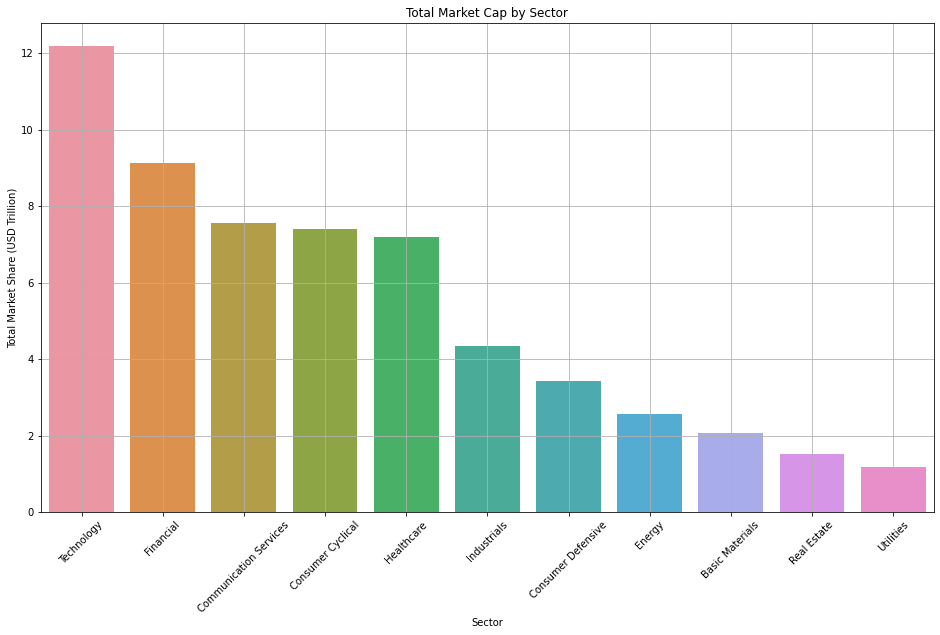

In [17]:
plt.figure(figsize=(16,9))
sns.barplot(x = df['Sector'], y = df['sum(Market_Cap)'] / 1000000000000, )
#sns.despine(left=True, bottom=True)
plt.xticks(rotation=45)
plt.title("Total Market Cap by Sector")
plt.xlabel("Sector")
plt.ylabel("Total Market Share (USD Trillion)")
plt.grid(True)
plt.show()

We can see that the technology sector is the most valuable sector currently with a total market cap of $12T USD. Other large sectors are Financial, Communication, and Consumer Cyclical. The lowest market cap sectors are Utilities, Real Estate and Basic Materials. 

We can also perform a query to find the market cap for individual companies in our database. 

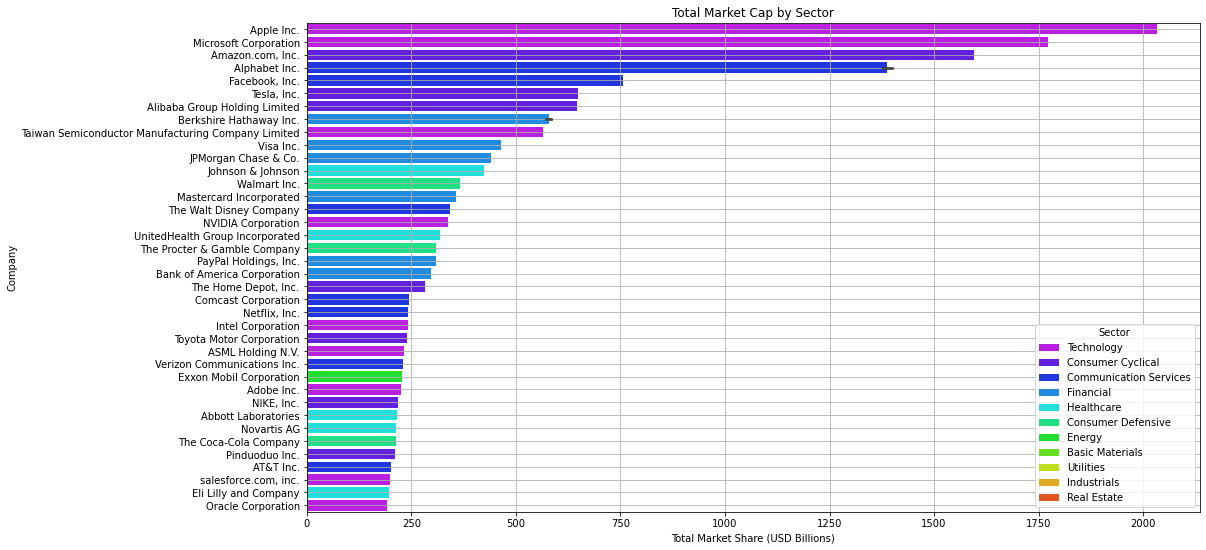

In [18]:
query = """
SELECT 
    Company, 
    Market_Cap,
    Sector,
    Industry,
    Country
FROM 
    stock_screener 
WHERE 
    Industry != 'Exchange Traded Fund' 
ORDER BY 
    Market_Cap 
DESC
"""

df = pd.read_sql(query, db)

plt.figure(figsize=(16,9))

sns.barplot(y = df['Company'].head(40), 
            x = df['Market_Cap'].head(40) / 1000000000, 
            hue = df['Sector'], 
            palette="gist_rainbow_r",
            dodge=False)

plt.title("Total Market Cap by Sector")
plt.xlabel("Total Market Share (USD Billions)")
plt.grid(True)
plt.show()

We can see that Apple Inc is currently (2/28/2021) the largest company in the world  with a market cap of over $2T USD. Companies that follow are Microsoft, Amazon, Google, Facebook and Tesla.

Since stock price is often linked with the financial performance of a company, we can extract the quarterly earnings data from our SimFin dataset that is in our database. We can pull the data for all the companies with over $400B USD Market Cap by combining the data from our `stock_screener` dataset with our `quarterly_data` dataset

In [19]:
query = """
SELECT
    stock_screener.Ticker,
    stock_screener.Company,
    stock_screener.Sector,
    stock_screener.Industry,
    quarterly_data.Report_Date,
    quarterly_data.Revenue,
    quarterly_data.Cost_of_Revenue,
    quarterly_data.Gross_Profit,
    quarterly_data.Operating_Expenses,
    quarterly_data.'Selling,_General_&_Administrative',
    quarterly_data.'Gross_Profit_Margin',
    quarterly_data.'Research_&_Development',
    quarterly_data.'Operating_Income_(Loss)',
    quarterly_data.Net_Income,
    quarterly_data.'Non-Operating_Income_(Loss)',
    quarterly_data.EBITDA,
    quarterly_data.Free_Cash_Flow
FROM
    quarterly_data
JOIN
    stock_screener
ON 
    stock_screener.Ticker = quarterly_data.Ticker
    WHERE stock_screener.Market_Cap > 400000000000

"""

df = pd.read_sql(query, db)

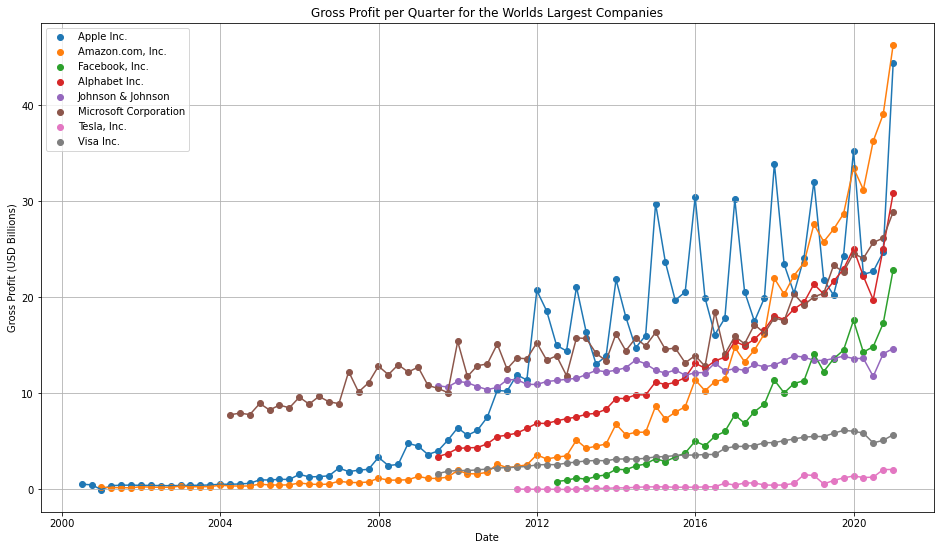

In [20]:
plt.figure(figsize=(16,9))
for i in df['Company'].unique():
    ix = df['Company'] == i
    temp = df[ix]
    plt.plot(pd.to_datetime(temp['Report_Date']), temp['Gross_Profit'] / 1000000000)
    plt.scatter(pd.to_datetime(temp['Report_Date']), temp['Gross_Profit'] / 1000000000, label = i)
    plt.legend()
plt.xlabel("Date")
plt.ylabel("Gross Profit (USD Billions)")
plt.title("Gross Profit per Quarter for the Worlds Largest Companies")
plt.grid(True)
plt.show()

We can see that both Amazon and Apple are both very cyclically financial cycles, while companies like Google and Facebook make stable profits. Telsa, despite being the sixth largest company in the world currently, have relatively low gross profits. 

We can check the insider trading activity against the stock price by combining both tables together. 

In [21]:
# ticker = input("Select a Ticker: ")
ticker = "FB"

In [22]:
query = f"""
SELECT 
    stock_prices.Date , 
    stock_prices.Adj_Close, 
    stock_prices.Ticker,
    insider_trading.InsiderName, 
    insider_trading.TradeType,
    insider_trading.Qty,
    insider_trading.Owned
FROM stock_prices
JOIN insider_trading
   ON 
       stock_prices.Date=insider_trading.Date
       AND 
           stock_prices.Ticker=insider_trading.Ticker
       AND 
           stock_prices.Ticker='{ticker}'
"""

df1 = pd.read_sql(query, db)

query = f"""
SELECT 
    *
FROM 
    stock_prices
WHERE
    stock_prices.Ticker = '{ticker}'
"""

df2 = pd.read_sql(query, db)


In [23]:
# Building a color dictionary for seaborn
color_dict = {"A - Grant": "gray",
                  "F - Tax": "yellow", 
                  "M - OptEx": "green", 
                  "S - Sale": "red", 
                  "S - Sale+OE": "red", 
                  "P - Purchase":"green", 
                  "G - Gift": "blue",
                  "C - Converted deriv":"grey",
                  "D - Sale to issuer": "red",
                  "X - OptEx" : "green",
                  "W - Inherited" : "blue"}

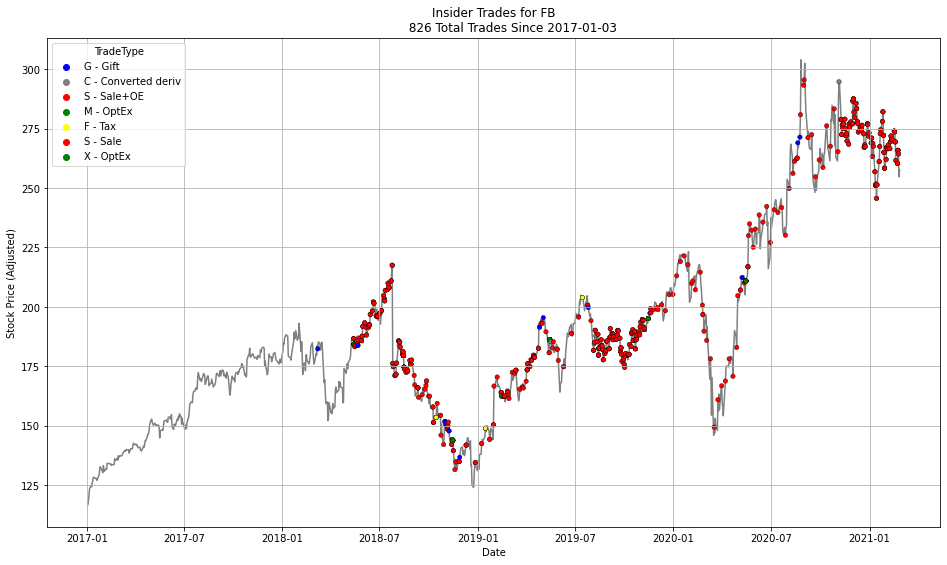

In [24]:

plt.figure(figsize=(16,9))
sns.lineplot(x = pd.to_datetime(df2['Date']), 
             y = df2['Adj_Close'],
            color = "gray",
            zorder= 0)

sns.scatterplot(x = pd.to_datetime(df1['Date']), 
                y = df1['Adj_Close'], 
                hue = df1['TradeType'],
                palette = color_dict,
                edgecolor="black",
                s = 20,
                zorder = 1)
plt.title(f"Insider Trades for {ticker}\n\
          {len(df1)} Total Trades Since {np.min(pd.to_datetime(df2['Date'])).strftime('%Y-%m-%d')}")
plt.ylabel("Stock Price (Adjusted)")
plt.grid(True)
plt.show()


We can visually check for insider trading by comparing the stock price with the time of transactions. If there are large amounts of shares sold before a sudden drop, it may raise some flags for us.

We can also check the individual holdings of each board member, officer, and 10% owner by cross referencing the number of shares they currently own the the value of the stock. If there are sudden drops in ownership for the company before large drops, that will also raise some red flags.

In [25]:
query = f"""
SELECT
    stock_prices.Date,
    stock_prices.Ticker,
    stock_prices.Adj_Close,
    insider_trading.InsiderName,
    insider_trading.Qty,
    insider_trading.TradeType,
    insider_trading.Owned,
    insider_Trading.ChangeOwned

FROM
    stock_prices
LEFT JOIN
    insider_trading
ON
    insider_trading.Date = stock_prices.Date
AND
    insider_trading.Ticker = stock_prices.Ticker

WHERE
    stock_prices.Ticker = '{ticker}'
"""

In [26]:
df = pd.read_sql(query, db)

In [27]:

def shares_ownership_interpolation(ser):
    """Interpolates a series with the previous known value"""
    shares = []
    prev_value = None
    
    for i in ser:
        # If there is no previous value and no current value, return None
        if np.isnan(i):
            shares.append(prev_value)
            
        # If there is a new value, assign it to the previous value and add it to the list
        elif i:
            prev_value = i
            shares.append(prev_value)
    # Sometimes values get overwritten due to some conflicts with the assignment in the SQL statement
    # This just patches it up a bit. It isn't a good method, but for data visualizations, there should be no difference
    if len(ser) != len(shares):
        for i in range(0, len(ser)-len(shares)):
            shares.append(prev_value)
            
    return np.array(shares)


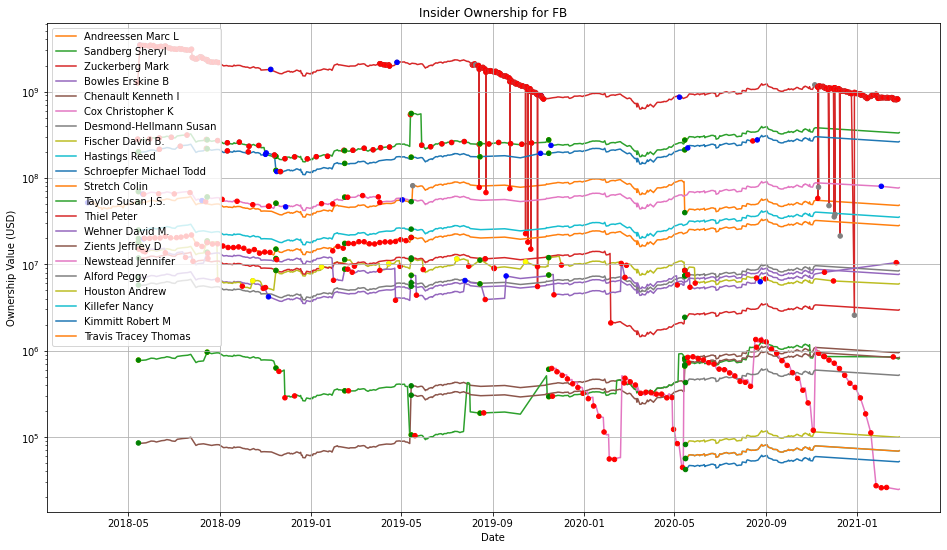

In [28]:
plt.figure(figsize=(16,9))
for person in df['InsiderName'].unique():
    try:
        temp = df[(df['InsiderName'].isna()) | (df['InsiderName'] == person)].reset_index()
        temp['TotalValue'] = shares_ownership_interpolation(temp['Owned']) * temp['Adj_Close']
        
        temp2 = temp[temp['InsiderName'] == person]
    
        plt.plot(pd.to_datetime(temp['Date']), 
                 temp['TotalValue'], 
                 label = person,
                 zorder = 0)
        
        plt.scatter(pd.to_datetime(temp2['Date']), 
                    temp2['TotalValue'], 
                    s = 20, 
                    color = temp2['TradeType'].apply(lambda x: color_dict[x]),
                    zorder = 1)
        
    except:
        print(f"Unable to plot data for {person}")
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylabel("Ownership Value (USD)")
plt.yscale("log")
plt.grid(True)
plt.title(f"Insider Ownership for {ticker}")
plt.show()

There are some visual errors when we check Facebooks insider activity due to the data source for our insider trades being a bit weird. Facebook was the only company I could find with this error and it only seems to happen with Mark Zuckerberg's data. I believe it has to do with cancelled trades. Ignoring those, we can see that Mark Zuckerberg has been liquidating his shares since 2018. This isn't unusual behavior for CEOs and other majority share holders for large companies since having 99.9999% of ones wealth connected to a single company is pretty risky. 

We can also see some trends in trading for individuals for this plot. We can see that Jennifer Newstead, an attorney who currently serves as the General Counsel at Facebook, sells of her shares in blocks shortly after being gifted them via bonuses.

We can also check another company like Amazon or Tesla

In [29]:
query = f"""
SELECT
    stock_prices.Date,
    stock_prices.Ticker,
    stock_prices.Adj_Close,
    insider_trading.InsiderName,
    insider_trading.Qty,
    insider_trading.TradeType,
    insider_trading.Owned,
    insider_Trading.ChangeOwned

FROM
    stock_prices
LEFT JOIN
    insider_trading
ON
    insider_trading.Date = stock_prices.Date
AND
    insider_trading.Ticker = stock_prices.Ticker

WHERE
    stock_prices.Ticker = 'AMZN'
"""

df = pd.read_sql(query, db)

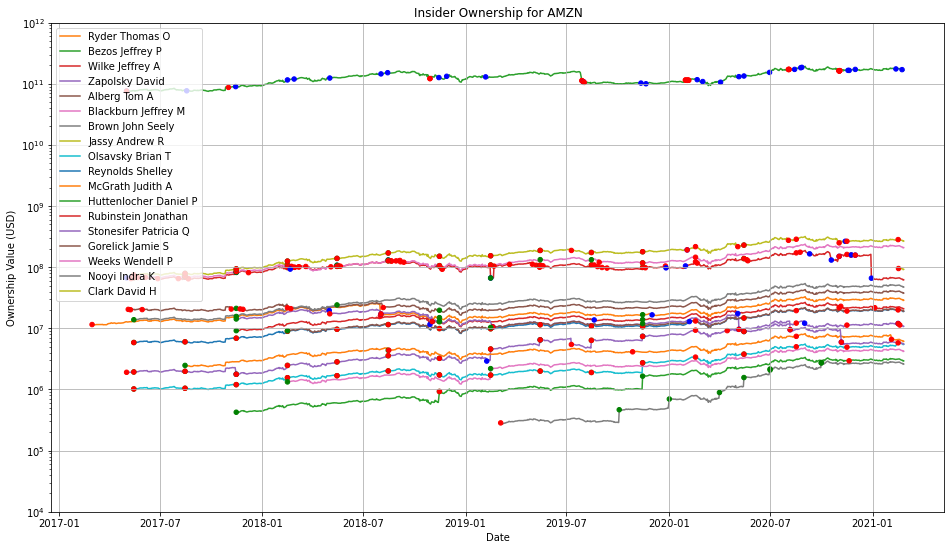

In [30]:
plt.figure(figsize=(16,9))

maxes = []

for person in df['InsiderName'].unique():
    try:
        temp = df[(df['InsiderName'].isna()) | (df['InsiderName'] == person)].reset_index()
        temp['TotalValue'] = shares_ownership_interpolation(temp['Owned']) * temp['Adj_Close']
        maxes.append(np.max(temp['TotalValue']))
        
        temp2 = temp[temp['InsiderName'] == person]
    
        plt.plot(pd.to_datetime(temp['Date']), 
                 temp['TotalValue'], 
                 label = person,
                 zorder = 0)
        
        plt.scatter(pd.to_datetime(temp2['Date']), 
                    temp2['TotalValue'], 
                    s = 20, 
                    color = temp2['TradeType'].apply(lambda x: color_dict[x]),
                    zorder = 1)
        
    except:
        print(f"Unable to plot data for {person}")
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylim(10000,1000000000000)
plt.ylabel("Ownership Value (USD)")
plt.grid(True)
plt.yscale("log")
plt.title(f"Insider Ownership for AMZN")
plt.show()

In [31]:
query = f"""
SELECT
    stock_prices.Date,
    stock_prices.Ticker,
    stock_prices.Adj_Close,
    insider_trading.InsiderName,
    insider_trading.Qty,
    insider_trading.TradeType,
    insider_trading.Owned,
    insider_Trading.ChangeOwned

FROM
    stock_prices
LEFT JOIN
    insider_trading
ON
    insider_trading.Date = stock_prices.Date
AND
    insider_trading.Ticker = stock_prices.Ticker

WHERE
    stock_prices.Ticker = 'TSLA'
"""

df = pd.read_sql(query, db)

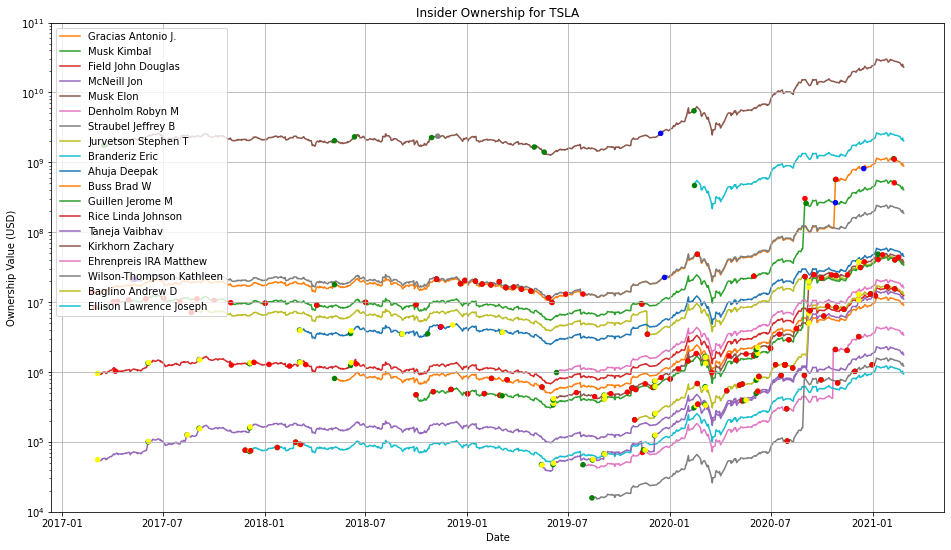

In [32]:
plt.figure(figsize=(16,9))
for person in df['InsiderName'].unique():
    try:
        temp = df[(df['InsiderName'].isna()) | (df['InsiderName'] == person)].reset_index()
        temp['TotalValue'] = shares_ownership_interpolation(temp['Owned']) * temp['Adj_Close']
        temp2 = temp[temp['InsiderName'] == person]
    
        plt.plot(pd.to_datetime(temp['Date']), 
                 temp['TotalValue'], 
                 label = person,
                 zorder = 0)
        
        plt.scatter(pd.to_datetime(temp2['Date']), 
                    temp2['TotalValue'], 
                    s = 20, 
                    color = temp2['TradeType'].apply(lambda x: color_dict[x]),
                    zorder = 1)
        
    except:
        print(f"Unable to plot data for {person}")
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylim(10000,100000000000)
plt.ylabel("Ownership Value (USD)")
plt.grid(True)
plt.yscale("log")
plt.title(f"Insider Ownership for TSLA")
plt.show()